In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import Input, Dense
sns.set()

2024-06-16 14:40:29.571789: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 14:40:29.598638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 14:40:29.728934: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 14:40:29.729859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 14:40:30.418614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
file_path = 'BTC-USD.csv' 
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values('Date')
print(df)

           Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
3525 2024-05-12  60793.503906  61818.156250  60632.601563  61448.394531   
3526 2024-05-13  61451.218750  63422.660156  60769.839844  62901.449219   
3527 2024-05-14  62900.773438  63092.125000  61123.765625  61552.789063   
3528 2024-05-15  61553.988281  66454.453125  61330.410156  66267.492188   
3529 2024-05-16  66253.937500  66591.296875  64678.179688  65109.988281   

         Adj Close       Volume  
0       457.334015     21056800  
1       424.440002     34483200

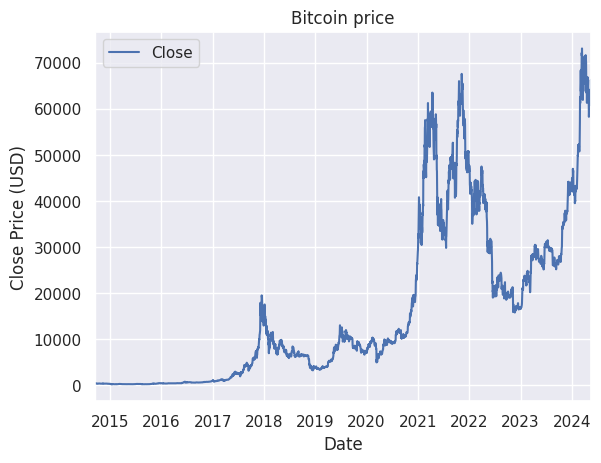

In [3]:
ax = df.plot(x='Date', y='Close')
ax.set_title('Bitcoin price')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
plt.show()

In [4]:
shifted_rows = 100
df['Prediction'] = df[['Close']].shift(-shifted_rows)
print(df['Prediction'])

0       327.924011
1       315.863007
2       317.239014
3       312.670013
4       310.737000
           ...    
3525           NaN
3526           NaN
3527           NaN
3528           NaN
3529           NaN
Name: Prediction, Length: 3530, dtype: float64


In [5]:
# Training dataset 
training_data = np.array(df[['Close']][:-shifted_rows])
print(training_data)

y = (df['Prediction'].values)[:-shifted_rows]
print(y)

[[  457.334015]
 [  424.440002]
 [  394.79599 ]
 ...
 [42583.582031]
 [42658.667969]
 [43084.671875]]
[  327.924011   315.863007   317.239014 ... 61552.789063 66267.492188
 65109.988281]


In [6]:
x_train, x_test, y_train, y_test = train_test_split(training_data, y, test_size=20)

## Linear Regression

In [7]:
linReg = LinearRegression()
linReg.fit(x_train, y_train)
linReg_confidence = linReg.score(x_test, y_test) 
print(linReg_confidence)

0.6669259855642309


In [8]:
future_values = np.array(df[['Close']][-shifted_rows:])
linReg_prediction = linReg.predict(future_values)

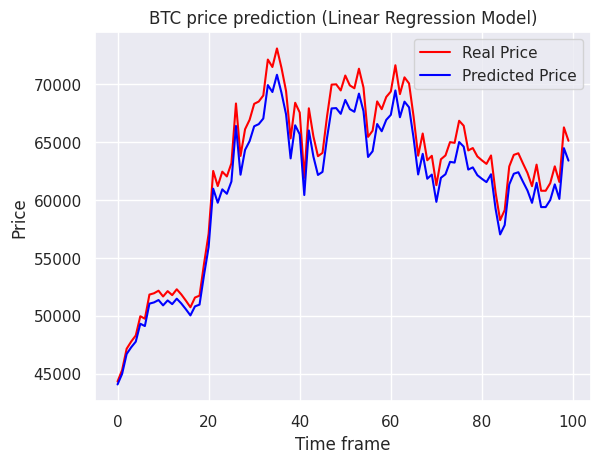

In [9]:
plt.plot(future_values, 'red', label = 'Real Price') 
plt.plot(linReg_prediction, 'blue', label='Predicted Price')
plt.xlabel('Time frame')
plt.ylabel('Price')
plt.title('BTC price prediction (Linear Regression Model)')
plt.legend()
plt.show()

## SVR Model 

In [10]:
svr_rbf = SVR(kernel='rbf', C= 1e2, gamma = 0.01) 
svr_poly = SVR(kernel = 'poly', C= 1e3, degree=2) 
y_rbf = svr_rbf.fit(x_train, y_train) 
y_poly = svr_poly.fit(x_train, y_train) 

In [11]:
future_values = np.array(df[['Close']][-shifted_rows:])
y_rbf_prediction = svr_rbf.predict(future_values) 
y_poly_prediction = svr_poly.predict(future_values)

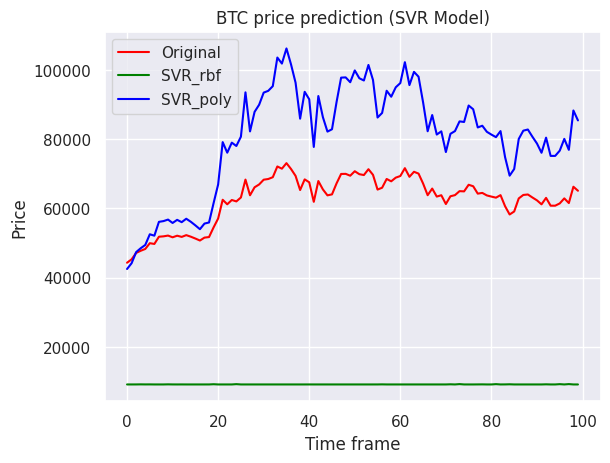

In [12]:
plt.plot(future_values, 'red', label = 'Original') 
plt.plot(y_rbf_prediction, 'green', label='SVR_rbf')
plt.plot(y_poly_prediction, 'blue', label='SVR_poly')
plt.xlabel('Time frame')
plt.ylabel('Price')
plt.title('BTC price prediction (SVR Model)')
plt.legend()
plt.show()

## Neural Network Model 

In [13]:
# Model architecture (MLP)
NN_model = Sequential([
    Dense(128, kernel_initializer='normal', activation='relu', input_dim=x_train.shape[1] ),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear'),
])

# Compile the model
NN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training and validation
history = NN_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 163221904.0000 - mean_absolute_error: 7308.0293 - val_loss: 102927760.0000 - val_mean_absolute_error: 5829.6846
Epoch 2/50
86/86 [==============================] - 0s 2ms/step - loss: 102143080.0000 - mean_absolute_error: 5817.3750 - val_loss: 102167840.0000 - val_mean_absolute_error: 5832.6348
Epoch 3/50
86/86 [==============================] - 0s 2ms/step - loss: 101055248.0000 - mean_absolute_error: 5777.0708 - val_loss: 102724424.0000 - val_mean_absolute_error: 5828.7432
Epoch 4/50
86/86 [==============================] - 0s 2ms/step - loss: 108506952.0000 - mean_absolute_error: 5982.0454 - val_loss: 114891912.0000 - val_mean_absolute_error: 6046.8555
Epoch 5/50
86/86 [==============================] - 0s 2ms/step - loss: 101277272.0000 - mean_absolute_error: 5814.1318 - val_loss: 101894032.0000 - val_mean_absolute_error: 5840.9800
Epoch 6/50
86/86 [==============================] - 0s 2ms/step - loss: 10040977

In [14]:
future_values = np.array(df[['Close']][-shifted_rows:])
NN_pred = NN_model.predict(future_values)

4/4 [==============================] - 0s 1ms/step


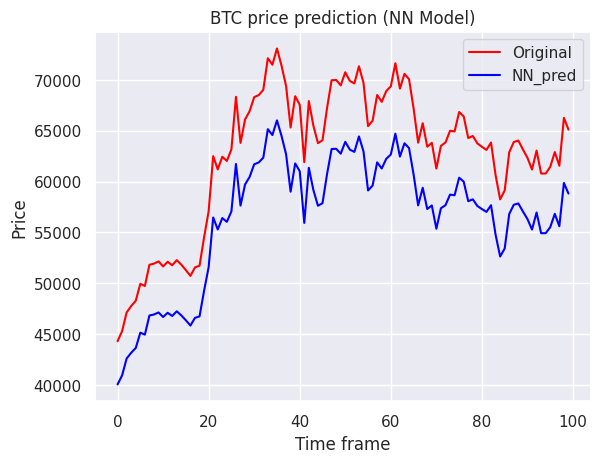

In [15]:
plt.plot(future_values, 'red', label = 'Original') 
plt.plot(NN_pred, 'blue', label='NN_pred')
plt.xlabel('Time frame')
plt.ylabel('Price')
plt.title('BTC price prediction (NN Model)')
plt.legend()
plt.show()

## XGBoost Model

In [16]:
# Define XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:absoluteerror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 50, alpha = 1, n_estimators = 1000)

# Train the model
xg_reg.fit(x_train,y_train)

# Predict on test data
future_values = np.array(df[['Close']][-shifted_rows:])
xgb_pred = xg_reg.predict(future_values)

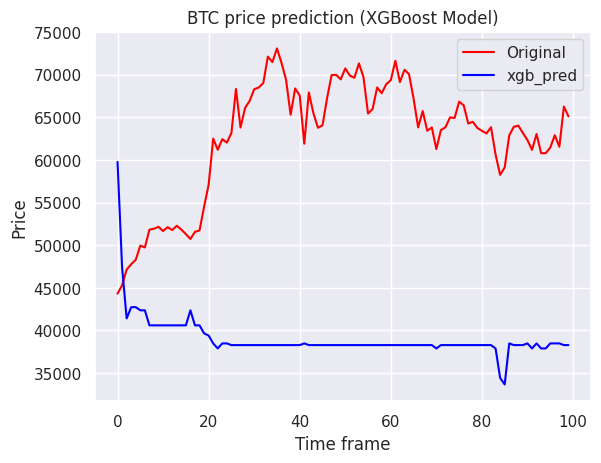

In [17]:
plt.plot(future_values, 'red', label = 'Original') 
plt.plot(xgb_pred, 'blue', label='xgb_pred')
plt.xlabel('Time frame')
plt.ylabel('Price')
plt.title('BTC price prediction (XGBoost Model)')
plt.legend()
plt.show()